# Filmic devblog 0: tone curve and color response

In this first devblog, we cover testing the concepts behind Filmic's features in Python. We'll be applying interpolated functions to alter images in a pleasing way, and confirming these ideas work before we try building UI and GPU shader code around them.

## Quick background

Analog photography is known for the *character* of its film stocks, e.g., the "[Fuji greens](https://old.reddit.com/r/AnalogCircleJerk/comments/clfde6/fuji_greens_or_portra_beans/)." I've been collecting a large catalog of analog photos for this project, and the most common characteristics I've noticed in film scans are the contrast of tones, shifted colors, film grain, and halation. Focusing on tuning these parameters, how well can we make a pleasing, filmic photo?


## Goals

Write some quick (in development time, not execution time) Python code to apply the aforementioned characteristics to digital photos. Explicitly:

1. remap RGB values for tone contrast adjustment
2. shift colors' hue, saturation, and luminosity with respect to their hue

As a side requirement, we need to interpolate our image transformations. Ultimately, these are mathematical functions, and we must define our input domain and how it maps to our output range. Well, there are a lot of possible pixel values, and we can't realistically define them individually

Instead, we'll define a handful of $(x, y)$ datapoints and interpolate between them; we can use this as an intuitive interface for making our adjustments.


## The code
Let's get started with our imports and some setup

In [8]:
# standard numpy and typing
import numpy as np

# image read, write, and conversion tools
import cv2
from PIL import Image

# to generate our cubic interpolation functions
from scipy.interpolate import interp1d

# nice image and plot display in our notebook
import matplotlib.pyplot as plt # for our image output

import plotly.graph_objects as go # for our plots, because plotly is awesome

# makes the size of our images a bit bigger in our notebook.
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

And now some reeusable visualization functions now so we don't clog up our code blocks later. The logic behind these isn't really important.

In [9]:
def read_img(filename):
	'''reads a local image file and returns its data as a numpy float32 ndarray.

	Note that the read pixel values are normalized between 0.0 and 1.0, i.e. they are not uint8!
	'''
	return np.array(Image.open(filename)).astype(np.float32) / 255 

def write_img(img, filename):
	'''input img should be float.'''
	Image.fromarray((img * 255).astype('uint8')).save(filename)

def show_img_rgb(img_rgb):
	'''shows RGB image. hides ugly default matplotlib axes'''
	plt.axis('off')
	plt.gcf().set_facecolor("#0f0f0f")
	plt.imshow(np.clip(img_rgb, 0, 1))

def show_img_left_right(img_left, img_right):
	'''display images beside each other'''
	fig, axarr = plt.subplots(1,2)
	fig.set_facecolor('#0f0f0f')
	fig.subplots_adjust(wspace = 0.03)
	axarr[0].imshow(img_left)
	axarr[0].axis('off')
	axarr[1].imshow(img_right)
	axarr[1].axis('off')

def plot_tone_curve(y_data, f_interp, label='tone'):
	'''plots tone curve with its interp function'''
	fig = go.Figure()
	fig.add_trace(
		go.Scatter(
			x = [0.0, 0.25, 0.5, 0.75, 1.0],
			y = y_data,
			mode ='markers',
			name = 'data',
			marker_color = 'hotpink',
			marker_size = 10
		)
	)

	x_curve = np.linspace(0.0, 1.0, num=100)

	fig.add_trace(
		go.Scatter(
			x = x_curve,
			y = f_interp(x_curve),
			name = 'interp',
			line_color = 'skyblue',
			line_width = 3,
		)
	)

	fig.update_layout(
		title = "tone curve",
		xaxis = dict(
			title = 'input tone',
			range = [-0.1, 1.1],
			dtick = 0.25
		),
		yaxis = dict(
			title = 'output ' + label,
			range = [-0.1, 1.1],
			dtick = 0.25
		),
		margin = dict(
			t = 40,
			b = 20,
			l = 20,
			r = 20
		)
	)

	fig.layout.template = 'plotly_dark'
	
	fig.show()

def plot_color_response_curve(y_data, f_interp, channel):
	'''plots hue response curve with its interp function,
	with labeling for its affected channel
	'''
	fig = go.Figure()
	fig.add_trace(
		go.Scatter(
			x = np.linspace(0.0, 360.0, num=13),
			y = y_data,
			mode ='markers',
			name = 'data',
			marker_color = 'hotpink',
			marker_size = 10
		)
	)

	x_curve = np.linspace(0.0, 360.0, num=180)

	fig.add_trace(
		go.Scatter(
			x = x_curve,
			y = f_interp(x_curve),
			name = 'interp',
			line_color = 'skyblue',
			line_width = 3,
		)
	)

	fig.update_layout(
		title = "color response curve",
		xaxis = dict(
			title = 'input hue',
			range = [0.0, 360.0],
			dtick = 30.0
		),
		yaxis = dict(
			title = channel + ' shift',
		),
		margin = dict(
			t=40,
			b=20,
			l=20,
			r=20
		)
	)

	fig.layout.template = 'plotly_dark'

	fig.show()

def rgb_to_hls(img_rgb):
	'''convert RGB to HLS. H is float in range of 0 to 360! H and S are 0.0 to 1.0'''
	return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)

def hls_to_rgb(img_hls):
	'''convert HLS to RGB. H is float in range of 0 to 360! H and S are 0.0 to 1.0'''
	return cv2.cvtColor(img_hls, cv2.COLOR_HLS2RGB)

We read in out first test image and see what it looks like. Note that we read in the image data as a `float32` with a value range of $[0.0, \, 1.0]$, which gives us better precision in our processing before outputting our final images as a `uint8`.

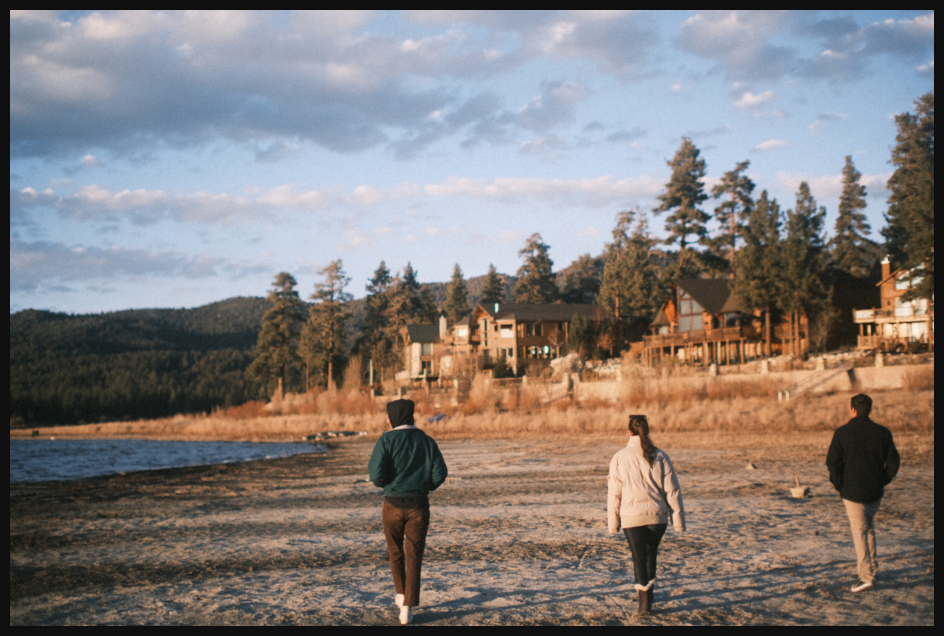

In [10]:
img_rgb1 = read_img('test_pic1.jpg')
show_img_rgb(img_rgb1)

Cool. Let's try to apply a basic tone curve to the image. We'll use five datapoints:

|   tone      | $x$    |  $y$    |
| ----------- | ------ |  ------ |
| blackpoint  | 0.0    |  0.2    |
| shadows     | 0.25   |  0.28   |
| midtones    | 0.5    |  0.5    |
| highlights  | 0.75   |  0.8    |
| whitepoint  | 1.0    |  1.0    |

Using `interp1d()`, we generate a function that will let us cubicly interpolate between these datapoints, yielding a nice sigmoid-ish curve that will squash our overall dynamic range and raise the blackpoint, but give us a bit more contrast around the midtones, and a bit less contrast around the shadows and highlights.

In [11]:
# common sigmoid-ish curve to apply to our image's RGB
tone_data_x = [0.0, 0.25, 0.5, 0.75, 1.0]
tone_data_y = [0.2, 0.28, 0.5, 0.80, 1.0]

# generate cubic interpolation function
f_tone_curve = interp1d(tone_data_x, tone_data_y, kind='cubic') 

plot_tone_curve(tone_data_y, f_tone_curve)

Just like we'd expect in the mathematical description of,

$$y = \mathrm{tone\_curve}(x) $$

NumPy let's us apply the curve with `f_tone_curve(img_rgb)`, which will apply the function to every individual element in the `ndArray`.

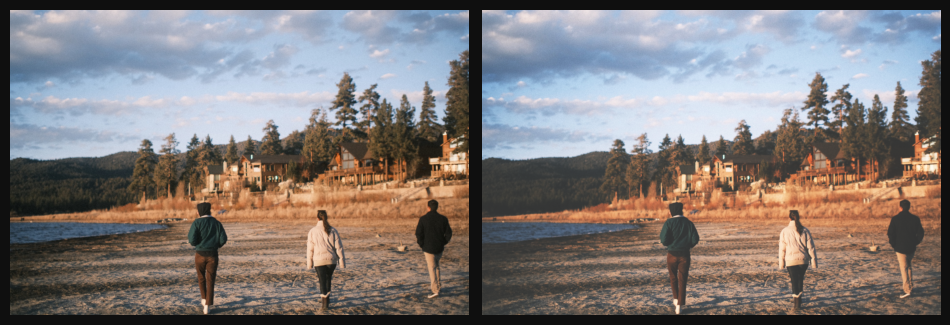

In [12]:
show_img_left_right(img_rgb1, f_tone_curve(img_rgb1))

Cool. Goal #1 is accomplished and it wasn't too hard. But now we're going to have to apply curves by separate HLS channels.

Let's create a new curve and call it a *color response* curve. We'll give it 13 datapoints, the first twelve are for every 30 deg of hue, and the last datapoint is to capture the last 30 deg between 330 and 360 on the hue circle before it repeats itself.

![color wheel](color_wheel.png)

In the first case, we'll be shifting hue with respect to hue:

$$ H' = H + \mathrm{color\_response}(H)$$

Let's shift the azure sky about halfway toward cyan, which is a characteristic sometimes seen in film.

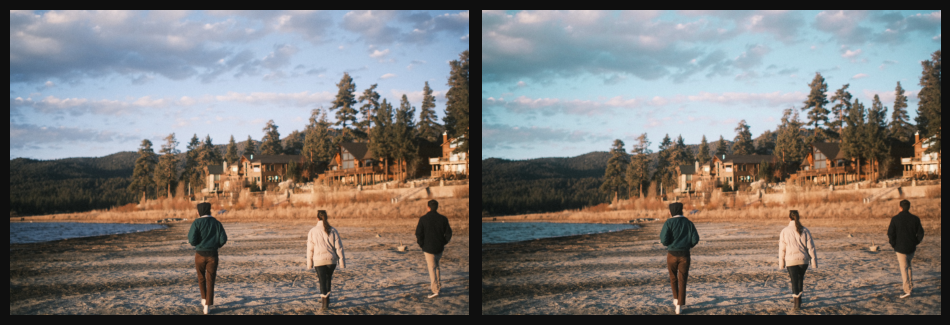

In [13]:
img_hls = rgb_to_hls(img_rgb1) # convert our rgb image to hls

# 12 colors for splitting the color wheel by 30 deg slices. The last element circles back to the first!
# we'll set azure to -15 degrees, putting it halfway to cyan.
color_response_data_y = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -15.0, 0.0, 0.0, 0.0, 0.0, 0.0] # shift azure -15.0 degrees
color_response_data_x = np.linspace(0.0, 360, num=13) # [0.0, 30.0, 60.0, ...]
f_color_response_curve = interp1d(color_response_data_x, color_response_data_y, kind='cubic')

# we operate on all the pixels of the image but only on the 0th channel, hue.
img_hls[:, :, 0] = img_hls[:, :, 0] + f_color_response_curve(img_hls[:, :, 0])
img_out = hls_to_rgb(img_hls)

# visualize our output
plot_color_response_curve(color_response_data_y, f_color_response_curve, 'hue')
show_img_left_right(img_rgb1, img_out)

This actually looks quite nice. Let's try raising the saturation 20% for azure and see how it looks. The equation for this should look like

$$ S' = S + \mathrm{color\_response}(H)$$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


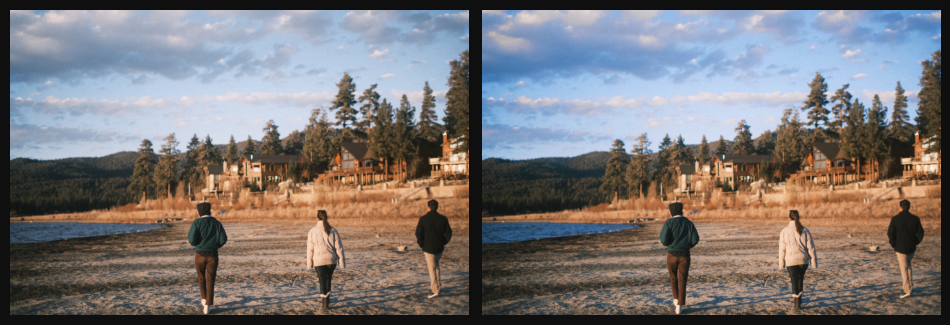

In [14]:
img_hls = rgb_to_hls(img_rgb1) # reset our img_hls

color_response_data_y = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0]) # increase saturation of azure 20%
color_response_data_x = np.linspace(0.0, 360.0, num=13)
f_color_response_curve = interp1d(color_response_data_x, color_response_data_y, kind='cubic')

# we operate on all the pixels of the image on saturation channel, with respect to the hue channel.
img_hls[:, :, 2] = img_hls[:, :, 2] + f_color_response_curve(img_hls[:, :, 0])
img_out = hls_to_rgb(img_hls)

plot_color_response_curve(color_response_data_y, f_color_response_curve, 'saturation')
show_img_left_right(img_rgb1, img_out)

So, we can generalize our shifting equation as

$$ Y' = Y + \mathrm{color\_response}(X)$$

where $X$ and $Y$ are color channels.

## Conclusion

Nice. We successfully demonstrated the effectiveness of our ideas. Admittedly, the tone curve is a pretty proven photo-editing tool, but we were able to use that as a foundation to implement our color response technique, which words splendidly.

In the next post, we'll focus on adding tone responsive film grain, and halation.

## Appendix

Some quick points worth noting:

### Hue vs. color

Color and hue are not the same; hue is a subcomponent of color. It's important to note this because our $\mathrm{color\_response()}$ is usually a function of hue, but it isn't always. We can also use it as a function of luminosity (or saturation), which is what we did with the grain application. But then you might ask, "why did you call it `f_tone_response()` in the code?" That's because, I think there needs to be an option of applying these effects both in the HSL *and* HSV color spaces in the app, and as I covered above, tonality is a good umbrella term for luminosity and value.

### Cubic rippples

In the cubic interpolation plots, there are ripples where the interpolation overshoots after hitting our target datapoint. This may not seem like a big deal, but it's counterintuitive to the user when there's additional change (however slight in areas zeroed out. To fix this, we use *monotonic* cubic interpolation in filmic, and we'll cover that implementation in the WebGL shader article.

## Thanks

If you find any typos, other errors, or want to make a comment, please contact me. And of course, feel free to reuse and remix any of this code. Please don't publicly repost these photos though! Only because they're my friends' likeness. Thanks!